In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from tqdm import tqdm 
from scipy.stats import chi2_contingency
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib

In [234]:
df=pd.read_csv('/Users/shrinarayan/Desktop/Prediction-PurchaseValues/dataset/train_data.csv')
df.shape

(116023, 52)

In [284]:
df[df['purchaseValue']>0]['purchaseValue']

4         88950000.0
5         28000000.0
6         80510000.0
20         6000000.0
21        31140000.0
             ...    
116000    17180000.0
116001    31180000.0
116012     9900000.0
116018    35180000.0
116022    81470000.0
Name: purchaseValue, Length: 23985, dtype: float64

In [235]:
# Count of sessions with purchaseValue == 0
zero_count = (df['purchaseValue'] == 0).sum()

# Total number of rows (for context)
total_count = len(df)

# Display
print(f"Number of sessions with purchaseValue = 0: {zero_count}")
print(f"Total number of sessions: {total_count}")
print(f"Percentage of zero purchase sessions: {100 * zero_count / total_count:.2f}%")


Number of sessions with purchaseValue = 0: 92038
Total number of sessions: 116023
Percentage of zero purchase sessions: 79.33%


In [236]:
df['made_purchase'] = df['purchaseValue'] > 0

In [237]:
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')],
      dtype=object)

In [238]:
df['gclIdPresent']=df['gclIdPresent']==1

In [239]:
df['gclIdPresent'].value_counts()

gclIdPresent
False    111728
True       4295
Name: count, dtype: int64

In [240]:
numerical_df=df.select_dtypes(include=['number'])

In [241]:
numerical_df.nunique()

purchaseValue                            6766
userId                                 100499
sessionNumber                             230
totals.visits                               1
sessionId                              107379
trafficSource.adwordsClickInfo.page         5
pageViews                                 175
locationZone                                1
totals.bounces                              1
date                                      638
totalHits                                 225
sessionStart                           107388
new_visits                                  1
dtype: int64

In [242]:
numerical_df.drop(
    columns=numerical_df.columns[numerical_df.nunique() == 1],
    inplace=True
)

In [243]:
numerical_df.nunique()

purchaseValue                            6766
userId                                 100499
sessionNumber                             230
sessionId                              107379
trafficSource.adwordsClickInfo.page         5
pageViews                                 175
date                                      638
totalHits                                 225
sessionStart                           107388
dtype: int64

In [244]:
numerical_df.isna().sum()

purchaseValue                               0
userId                                      0
sessionNumber                               0
sessionId                                   0
trafficSource.adwordsClickInfo.page    111742
pageViews                                   8
date                                        0
totalHits                                   0
sessionStart                                0
dtype: int64

In [245]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# def get_feature_importance_cv(X, y, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     importances_array = np.zeros((n_splits, X.shape[1]))

#     for fold, (train_index, test_index) in enumerate(tqdm(kf.split(X), total=n_splits, desc="Cross-validation")):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         model = RandomForestRegressor(random_state=42)
#         model.fit(X_train, y_train)
#         importances_array[fold] = model.feature_importances_

#     mean_importances = np.mean(importances_array, axis=0)
#     std_importances = np.std(importances_array, axis=0)
#     importance_series = pd.Series(mean_importances, index=X.columns)
#     return importance_series, std_importances

# # A. Original with IDs
# X_full = df.select_dtypes(include=['int64', 'float64']).drop(columns=['purchaseValue'])
# y = df['purchaseValue']
# importances_full, std_full = get_feature_importance_cv(X_full, y)

# # B. Dropped IDs
# X_reduced = X_full.drop(columns=['userId', 'sessionId'])
# importances_reduced, std_reduced = get_feature_importance_cv(X_reduced, y)

# # Plot side-by-side comparison (optional)
# plt.figure(figsize=(12, 6))
# importances_full.sort_values(ascending=False).plot(kind='bar', alpha=0.5, label='With IDs')
# importances_reduced.sort_values(ascending=False).plot(kind='bar', alpha=0.5, label='Without IDs', color='orange')
# plt.legend()
# plt.title('Feature Importance Comparison: With vs Without userId/sessionId')
# plt.tight_layout()
# plt.show()


In [246]:
numerical_df.drop(columns=['userId','sessionId'],inplace=True)

In [247]:
numerical_df.head()

,purchaseValue,sessionNumber,trafficSource.adwordsClickInfo.page,pageViews,date,totalHits,sessionStart
0,0.0,1,NaN,1.0,20170714,1,1500100799
1,0.0,1,NaN,1.0,20170519,1,1495262065
2,0.0,2,NaN,6.0,20171020,6,1508510328
3,0.0,1,NaN,1.0,20170103,1,1483431838
4,88950000.0,1,NaN,54.0,20161006,66,1475804633


In [248]:
numerical_df['trafficSource.adwordsClickInfo.page'].isna().sum()

np.int64(111742)

In [249]:
# --- Assumption ---
# I'm assuming your original 'df' with the 'made_purchase' column is available
# and has the same index as 'numerical_df'.

# 1. Create a temporary DataFrame for this specific analysis
analysis_df = pd.DataFrame()

# 2. Add the feature column from your numerical_df
analysis_df['ad_page'] = numerical_df['trafficSource.adwordsClickInfo.page']

# 3. Add the target column from your original full DataFrame
analysis_df['made_purchase'] = df['made_purchase']

# 4. Process the feature: Fill NaN with 0 to create a "Not from Ad" category
#    and convert to integer for cleaner labels.
analysis_df['ad_page'] = analysis_df['ad_page'].fillna(0).astype(int)

/var/folders/dm/98lvl5s96xn5qcs0j_dnn9l80000gn/T/ipykernel_10389/3491550447.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_rate, x='ad_page', y='made_purchase', palette='mako')


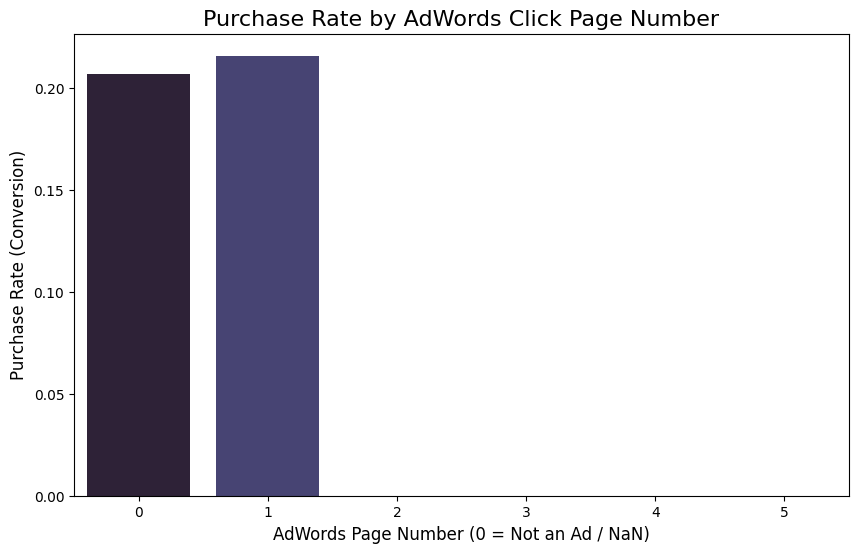

Purchase Rate per Category:
   ad_page  made_purchase
0        0       0.206511
1        1       0.215607
2        2       0.000000
3        3       0.000000
4        4       0.000000
5        5       0.000000


In [250]:
# Calculate the mean of 'made_purchase' (which is the purchase rate) for each ad_page category
purchase_rate = analysis_df.groupby('ad_page')['made_purchase'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=purchase_rate, x='ad_page', y='made_purchase', palette='mako')

plt.title('Purchase Rate by AdWords Click Page Number', fontsize=16)
plt.xlabel('AdWords Page Number (0 = Not an Ad / NaN)', fontsize=12)
plt.ylabel('Purchase Rate (Conversion)', fontsize=12)
plt.show()

print("Purchase Rate per Category:")
print(purchase_rate)

In [251]:
print(df['trafficSource.adwordsClickInfo.page'].value_counts())
trafficSource_adwordsClickInfo_page_df=df[df['purchaseValue']>0][['purchaseValue','trafficSource.adwordsClickInfo.page']]
trafficSource_adwordsClickInfo_page_df['trafficSource.adwordsClickInfo.page'].value_counts()

trafficSource.adwordsClickInfo.page
1.0    4216
2.0      50
3.0      12
4.0       2
5.0       1
Name: count, dtype: int64


trafficSource.adwordsClickInfo.page
1.0    909
Name: count, dtype: int64

In [252]:
# Create the new engineered feature
def bin_ad_page(page_num):
    if pd.isna(page_num):
        return 0  # Category for 'Not an Ad'
    elif page_num == 1.0:
        return 1  # Category for 'Page 1'
    else:
        return 2  # Category for 'Page 2+'

# Apply this function to create a new, clean categorical column
df['ad_page_binned'] = df['trafficSource.adwordsClickInfo.page'].apply(bin_ad_page)

# Now, drop the original noisy column
df = df.drop(columns=['trafficSource.adwordsClickInfo.page'])
numerical_df.drop(columns=['trafficSource.adwordsClickInfo.page'],inplace=True)

# --- In your modeling pipeline ---
# 'ad_page_binned' should now be treated as a categorical feature and be one-hot encoded.

In [253]:
numerical_df.head()

,purchaseValue,sessionNumber,pageViews,date,totalHits,sessionStart
0,0.0,1,1.0,20170714,1,1500100799
1,0.0,1,1.0,20170519,1,1495262065
2,0.0,2,6.0,20171020,6,1508510328
3,0.0,1,1.0,20170103,1,1483431838
4,88950000.0,1,54.0,20161006,66,1475804633


In [254]:
# --- Date and Timestamp Engineering ---

# Convert 'date' to datetime and extract features
numerical_df['date'] = pd.to_datetime(numerical_df['date'], format='%Y%m%d')
numerical_df['sessionYear'] = numerical_df['date'].dt.year
numerical_df['sessionMonth'] = numerical_df['date'].dt.month
numerical_df['sessionDayOfWeek'] = numerical_df['date'].dt.dayofweek # Monday=0, Sunday=6

# Convert 'sessionStart' (Unix timestamp) to datetime and extract hour
numerical_df['sessionHour'] = pd.to_datetime(numerical_df['sessionStart'], unit='s').dt.hour

# Drop the original columns as they are now redundant
numerical_df = numerical_df.drop(columns=['date', 'sessionStart'])


# --- Imputation for pageViews and adwordsClickInfo.page ---
numerical_df['pageViews'] = numerical_df['pageViews'].fillna(numerical_df['pageViews'].median())


In [255]:
numerical_df

,purchaseValue,sessionNumber,pageViews,totalHits,sessionYear,sessionMonth,sessionDayOfWeek,sessionHour
0,0.0,1,1.0,1,2017,7,4,6
1,0.0,1,1.0,1,2017,5,4,6
2,0.0,2,6.0,6,2017,10,4,14
3,0.0,1,1.0,1,2017,1,1,8
4,88950000.0,1,54.0,66,2016,10,3,1
...,...,...,...,...,...,...,...,...
116018,35180000.0,1,26.0,28,2017,7,0,19
116019,0.0,1,1.0,1,2016,11,1,16
116020,0.0,2,1.0,1,2016,8,4,8
116021,0.0,1,2.0,2,2017,10,0,14


In [256]:
# # Separate features and target
# X = numerical_df.drop(columns=['purchaseValue'])
# y = numerical_df['purchaseValue']
# feature_names = X.columns

# # Cross-validation setup
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# importances_array = np.zeros((n_splits, len(feature_names)))

# # Cross-validated Random Forest training
# for fold, (train_index, test_index) in enumerate(tqdm(kf.split(X), total=n_splits, desc="Cross-validation")):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     model = RandomForestRegressor(random_state=42)
#     model.fit(X_train, y_train)
#     importances_array[fold] = model.feature_importances_

# # Compute average and std deviation of importances
# mean_importances = np.mean(importances_array, axis=0)
# std_importances = np.std(importances_array, axis=0)
# importance_series = pd.Series(mean_importances, index=feature_names)

# # Sort and plot
# sorted_importance = importance_series.sort_values()
# sorted_std = std_importances[np.argsort(mean_importances)]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_importance.index, sorted_importance.values, xerr=sorted_std, color='skyblue', alpha=0.8)
# plt.title('Feature Importance (Random Forest with Cross-Validation)')
# plt.xlabel('Average Importance Score')
# plt.tight_layout()
# plt.show()


In [257]:
categorical_df = df.select_dtypes(include=['object', 'category']).copy()
df.shape

(116023, 53)

In [258]:
categorical_df = categorical_df.loc[:, categorical_df.nunique() > 1]

In [259]:
categorical_df.shape

(116023, 20)

In [260]:
# Assuming 'categorical_df' and the original 'df' with the target are available

# Get the list of columns we are analyzing
cat_cols = categorical_df.columns.tolist()

# Create a summary DataFrame
cat_summary = pd.DataFrame({
    'Unique_Values': categorical_df[cat_cols].nunique(),
    'Missing_Values': categorical_df[cat_cols].isnull().sum(),
    'Missing_Percentage': (categorical_df[cat_cols].isnull().sum() / len(categorical_df)) * 100
}).sort_values(by='Unique_Values', ascending=False)

print("Summary of Categorical Features:")
print(cat_summary)

Summary of Categorical Features:
                                              Unique_Values  Missing_Values  \
trafficSource.referralPath                              941           73309   
geoNetwork.city                                         695               0   
trafficSource.keyword                                   566           71861   
geoNetwork.region                                       388               0   
locationCountry                                         193               0   
trafficSource                                           161               0   
geoNetwork.metro                                        104               0   
trafficSource.adContent                                  53          113060   
browser                                                  34               0   
trafficSource.campaign                                   28               0   
geoNetwork.subContinent                                  23               0   
os                 

In [261]:
df['made_purchase']=df['purchaseValue']>0

In [262]:
df.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits,made_purchase,ad_page_binned
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0,False,0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0,False,0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN,False,0
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0,False,0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0,True,0


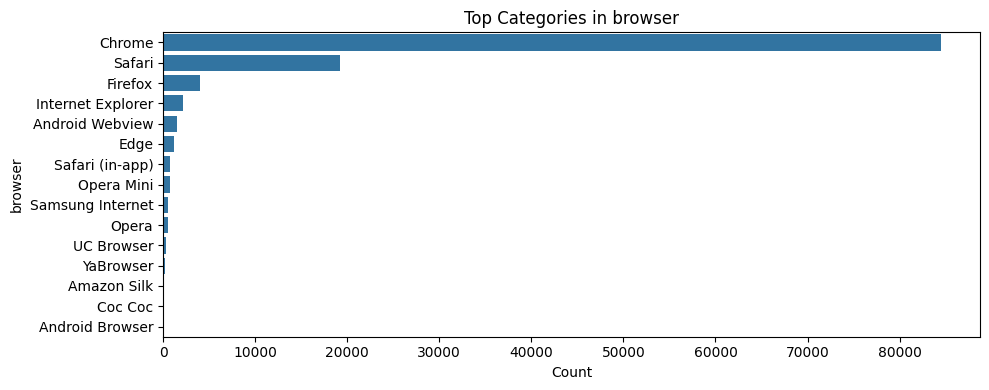

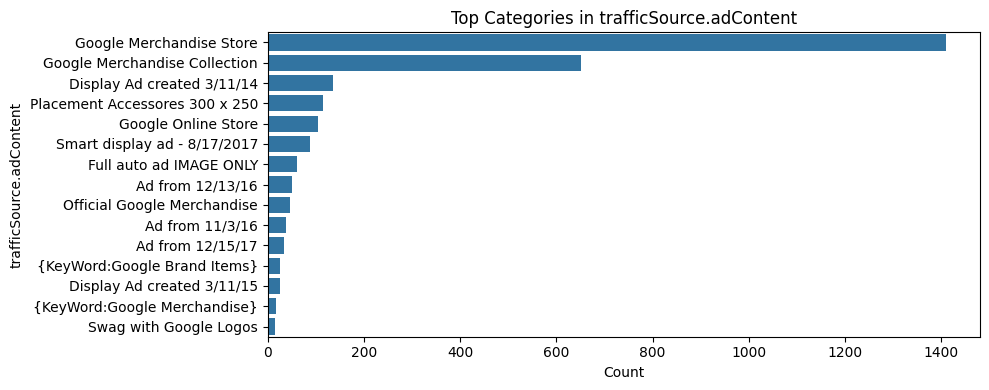

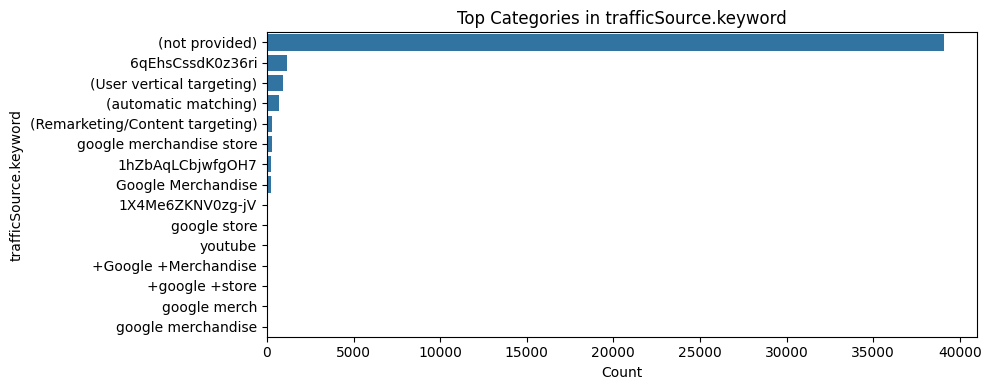

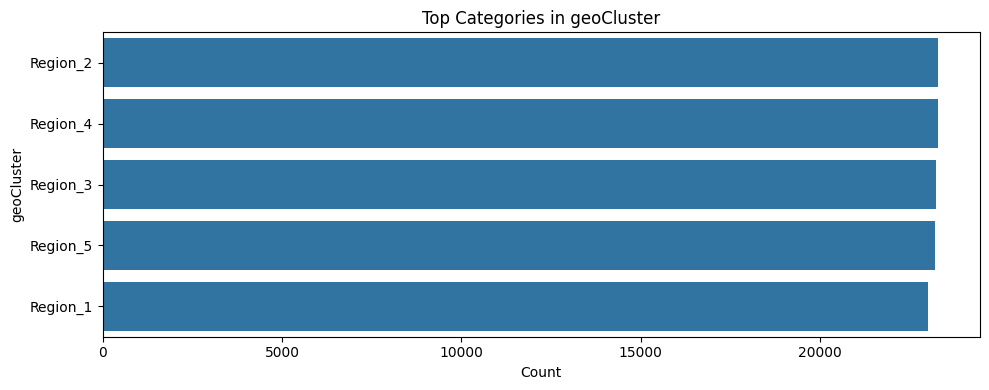

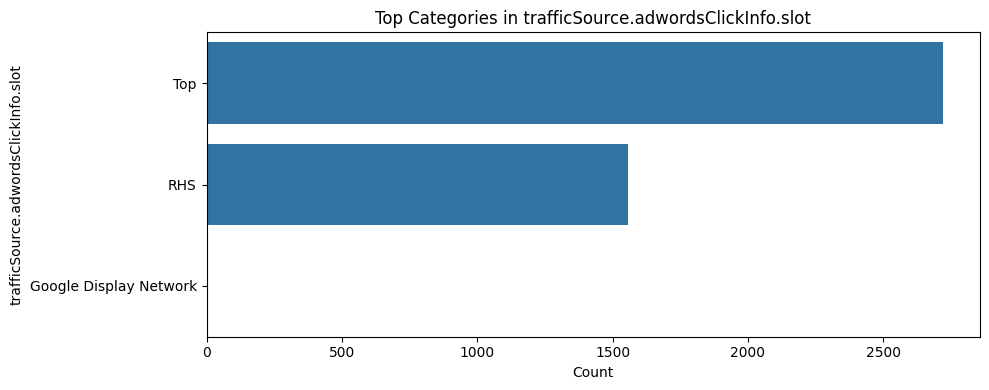

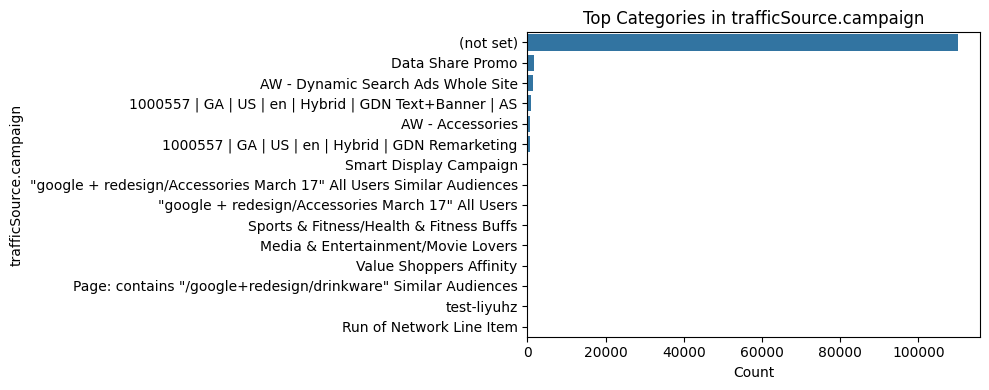

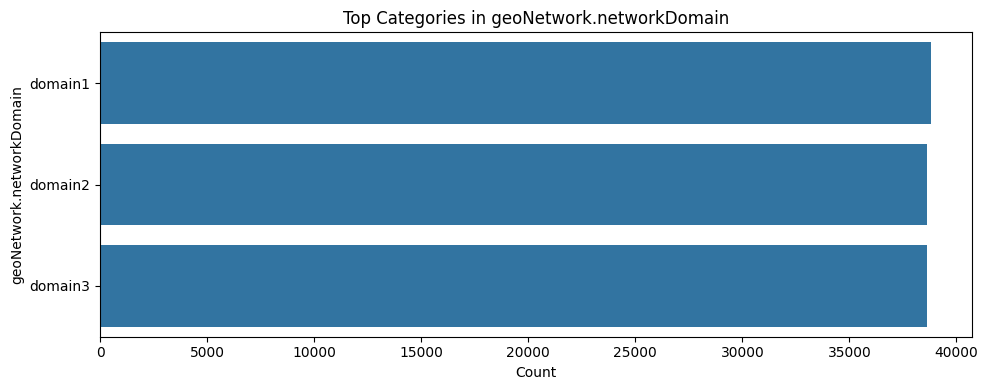

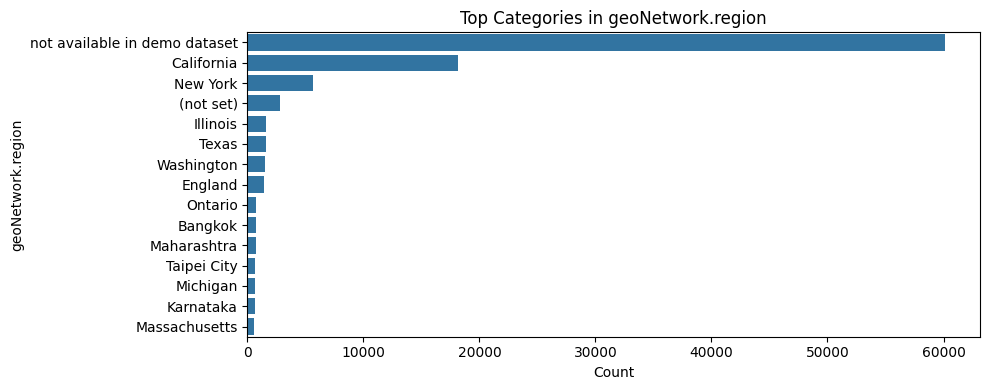

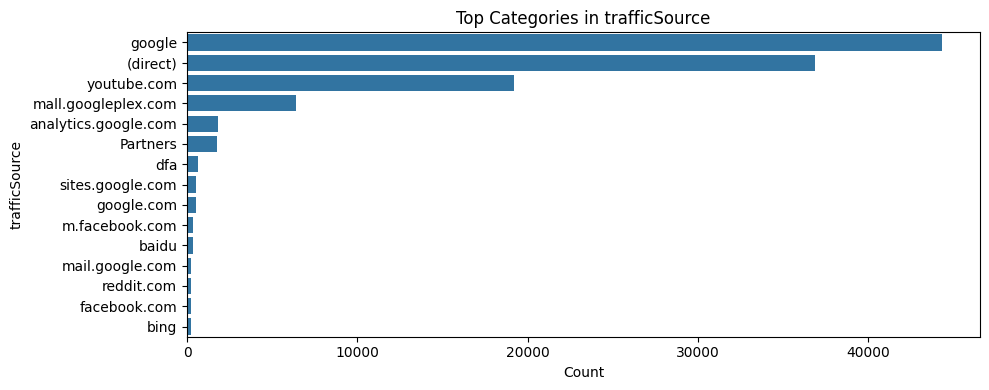

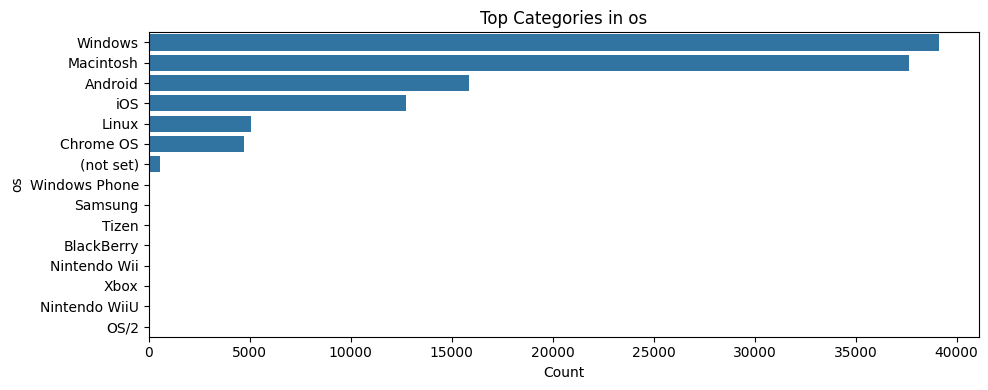

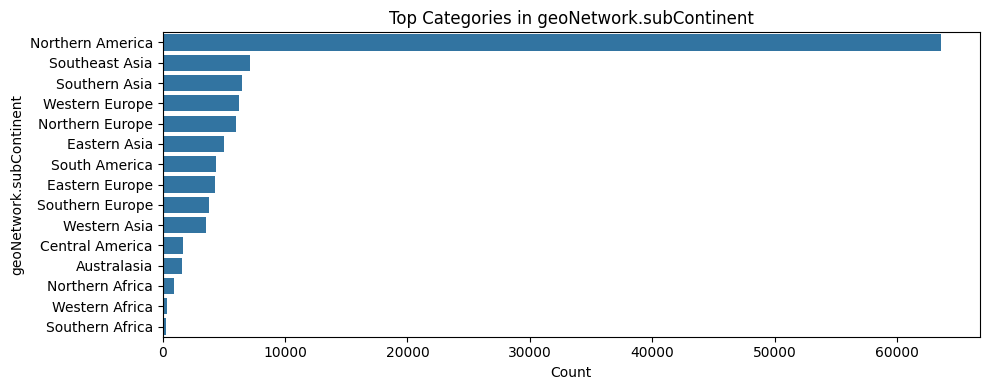

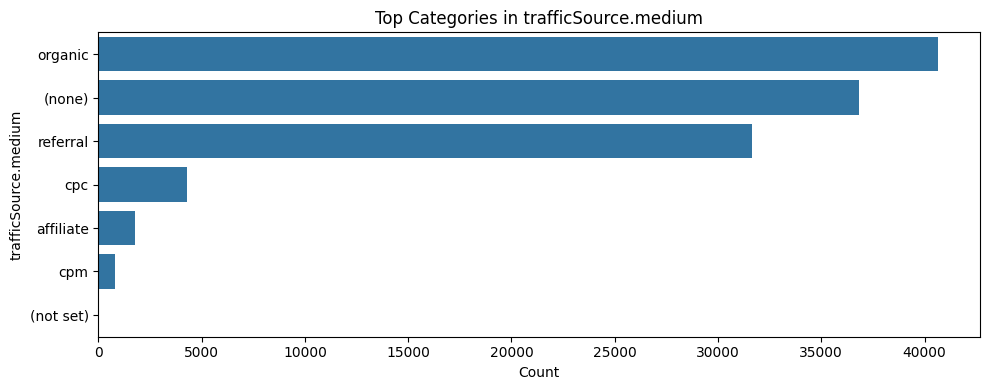

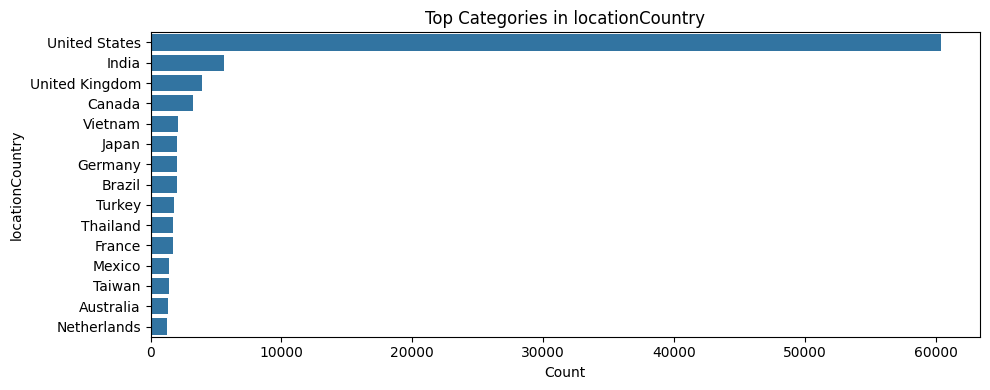

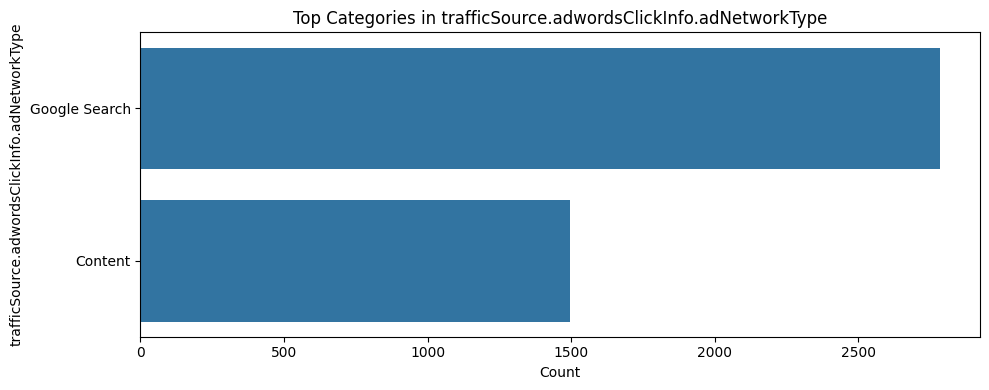

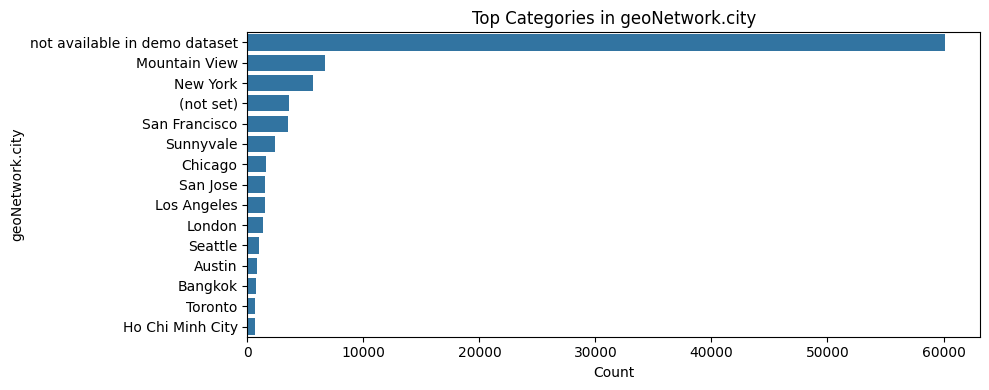

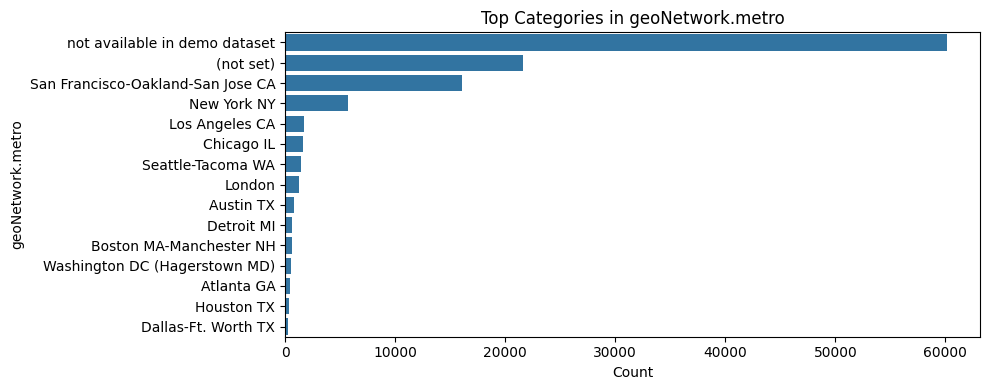

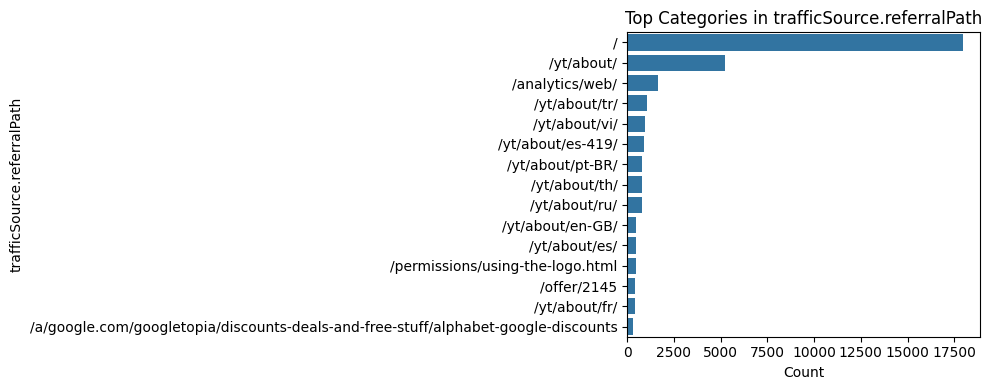

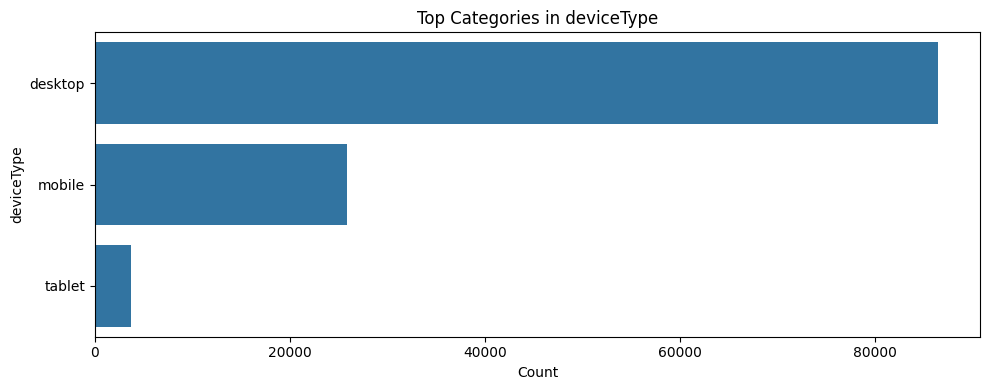

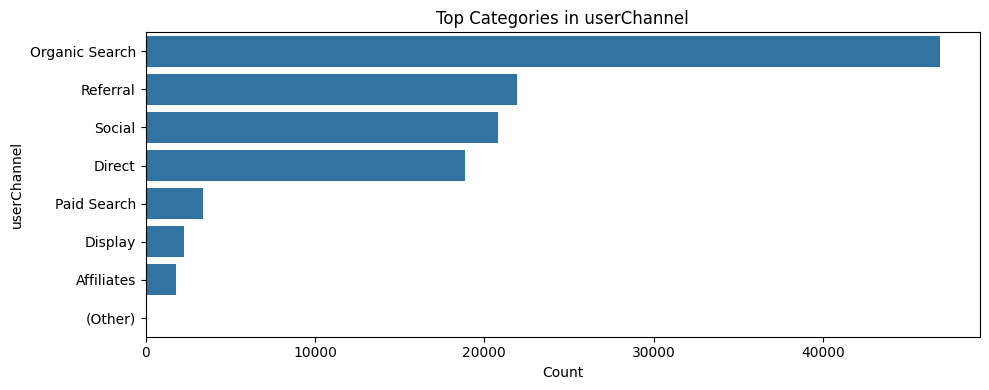

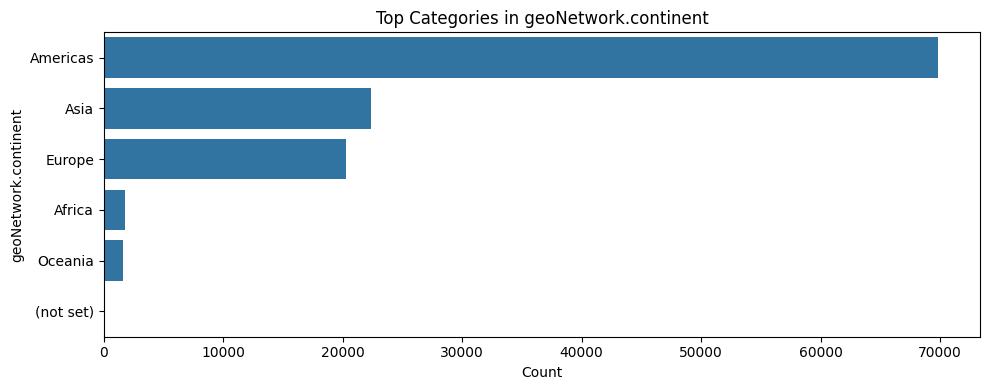

In [263]:

for col in categorical_df.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=categorical_df[col], order=categorical_df[col].value_counts().index[:15])
    plt.title(f'Top Categories in {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [264]:
categorical_df.nunique()

browser                                          34
trafficSource.adContent                          53
trafficSource.keyword                           566
geoCluster                                        5
trafficSource.adwordsClickInfo.slot               3
trafficSource.campaign                           28
geoNetwork.networkDomain                          3
geoNetwork.region                               388
trafficSource                                   161
os                                               18
geoNetwork.subContinent                          23
trafficSource.medium                              7
locationCountry                                 193
trafficSource.adwordsClickInfo.adNetworkType      2
geoNetwork.city                                 695
geoNetwork.metro                                104
trafficSource.referralPath                      941
deviceType                                        3
userChannel                                       8
geoNetwork.c

In [265]:
categorical_df.isna().sum()

browser                                              0
trafficSource.adContent                         113060
trafficSource.keyword                            71861
geoCluster                                           0
trafficSource.adwordsClickInfo.slot             111742
trafficSource.campaign                               0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
trafficSource                                        0
os                                                   0
geoNetwork.subContinent                              0
trafficSource.medium                                 0
locationCountry                                      0
trafficSource.adwordsClickInfo.adNetworkType    111742
geoNetwork.city                                      0
geoNetwork.metro                                     0
trafficSource.referralPath                       73309
deviceType                                           0
userChanne

In [266]:
# Replace missing categorical values with 'missing'
categorical_df = categorical_df.fillna('missing')


In [267]:
y = df['purchaseValue']
encoded_categorical_df = pd.DataFrame(index=categorical_df.index)
global_mean = y.mean()

for col in categorical_df.columns:
    # Compute mean purchase value for each category
    category_means = df.groupby(col)['purchaseValue'].mean()
    
    # Map means to the column
    encoded_categorical_df[col] = categorical_df[col].map(category_means)
    
    # Replace NaNs (unseen categories) with global mean
    encoded_categorical_df[col] = encoded_categorical_df[col].fillna(global_mean)

In [268]:
numerical_df.isna().sum()

purchaseValue       0
sessionNumber       0
pageViews           0
totalHits           0
sessionYear         0
sessionMonth        0
sessionDayOfWeek    0
sessionHour         0
dtype: int64

RMSE: 150505513.35
R² Score: 0.3541


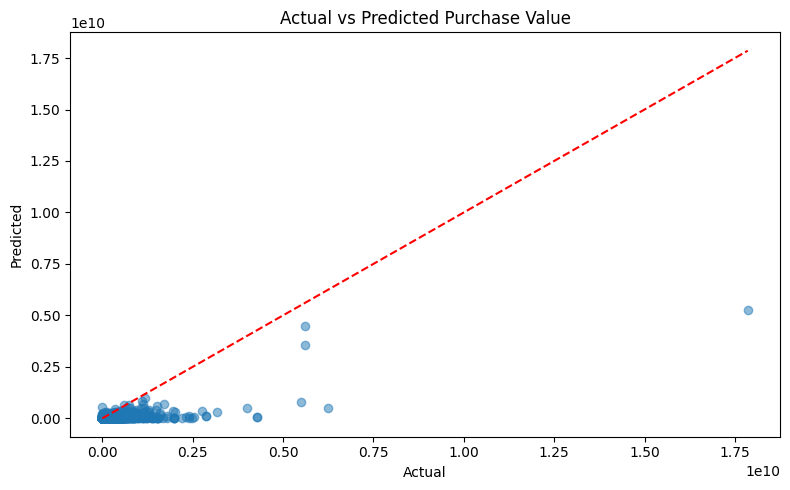

In [269]:
from sklearn.model_selection import StratifiedShuffleSplit

# Step 1: Combine features
X = pd.concat([numerical_df, encoded_categorical_df], axis=1)
X = X.drop(columns=['purchaseValue'], errors='ignore')  # optional safeguard

# Step 2: Log-transform the target
y = df['purchaseValue']
y_log = np.log1p(y)  # log(1 + y)

# Step 3: Create a stratification label: purchase or not
strat_labels = (y > 0).astype(int)  # 0 = no purchase, 1 = purchase

# Step 4: Stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X, strat_labels):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

# Step 5: Train model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Step 6: Predict and inverse transform
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Step 7: Evaluate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Step 8: Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([0, max(y_test_orig)], [0, max(y_test_orig)], color='red', linestyle='--')
plt.title("Actual vs Predicted Purchase Value")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


In [270]:

scores = cross_val_score(model, X, y_log, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())


Cross-validated R² scores: [0.82746949 0.81824051 0.83170304 0.82863811 0.824913  ]
Average R²: 0.8261928301002073


In [271]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


pageViews           0.726542
locationCountry     0.055294
totalHits           0.028672
sessionNumber       0.027240
sessionHour         0.025432
sessionMonth        0.020146
sessionDayOfWeek    0.015633
geoNetwork.city     0.013485
os                  0.012271
geoCluster          0.011394
dtype: float64

In [272]:
encoded_categorical_df.head()

,browser,trafficSource.adContent,trafficSource.keyword,geoCluster,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,geoNetwork.networkDomain,geoNetwork.region,trafficSource,os,geoNetwork.subContinent,trafficSource.medium,locationCountry,trafficSource.adwordsClickInfo.adNetworkType,geoNetwork.city,geoNetwork.metro,trafficSource.referralPath,deviceType,userChannel,geoNetwork.continent
0,1.023996e+07,2.656393e+07,2.656393e+07,2.886466e+07,2.656393e+07,2.725319e+07,2.659935e+07,4.720018e+07,3.522097e+04,2.058279e+07,4.676389e+07,1.764453e+07,4.826599e+07,2.656393e+07,1.135221e+07,4.732689e+07,0.000000e+00,3.424728e+07,4.696204e+05,4.304335e+07
1,3.217082e+07,2.656393e+07,2.656393e+07,2.945375e+07,2.656393e+07,2.725319e+07,2.685677e+07,4.268160e+07,4.573531e+07,4.543571e+07,4.676389e+07,4.573531e+07,4.826599e+07,2.656393e+07,3.847536e+07,4.088950e+07,2.656393e+07,3.424728e+07,4.332910e+07,4.304335e+07
2,3.217082e+07,2.656393e+07,1.459917e+07,2.886466e+07,2.656393e+07,2.725319e+07,2.659935e+07,0.000000e+00,1.505107e+07,2.058279e+07,6.266551e+05,1.442734e+07,1.750343e+05,2.656393e+07,0.000000e+00,3.811578e+06,2.656393e+07,3.424728e+07,1.469966e+07,7.576836e+05
3,7.490626e+06,2.656393e+07,2.656393e+07,2.507895e+07,2.656393e+07,2.725319e+07,2.685677e+07,2.167464e+07,3.522097e+04,2.058279e+07,4.640272e+06,1.764453e+07,6.797011e+06,2.656393e+07,2.167464e+07,2.167464e+07,0.000000e+00,3.424728e+07,4.696204e+05,1.645135e+06
4,3.217082e+07,2.656393e+07,2.656393e+07,2.945375e+07,2.656393e+07,2.725319e+07,2.659935e+07,2.167464e+07,4.573531e+07,2.058279e+07,4.676389e+07,4.573531e+07,4.826599e+07,2.656393e+07,2.167464e+07,2.167464e+07,2.656393e+07,3.424728e+07,4.332910e+07,4.304335e+07


In [273]:
numerical_df.head()

,purchaseValue,sessionNumber,pageViews,totalHits,sessionYear,sessionMonth,sessionDayOfWeek,sessionHour
0,0.0,1,1.0,1,2017,7,4,6
1,0.0,1,1.0,1,2017,5,4,6
2,0.0,2,6.0,6,2017,10,4,14
3,0.0,1,1.0,1,2017,1,1,8
4,88950000.0,1,54.0,66,2016,10,3,1


In [274]:
encoded_categorical_df.head()

,browser,trafficSource.adContent,trafficSource.keyword,geoCluster,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,geoNetwork.networkDomain,geoNetwork.region,trafficSource,os,geoNetwork.subContinent,trafficSource.medium,locationCountry,trafficSource.adwordsClickInfo.adNetworkType,geoNetwork.city,geoNetwork.metro,trafficSource.referralPath,deviceType,userChannel,geoNetwork.continent
0,1.023996e+07,2.656393e+07,2.656393e+07,2.886466e+07,2.656393e+07,2.725319e+07,2.659935e+07,4.720018e+07,3.522097e+04,2.058279e+07,4.676389e+07,1.764453e+07,4.826599e+07,2.656393e+07,1.135221e+07,4.732689e+07,0.000000e+00,3.424728e+07,4.696204e+05,4.304335e+07
1,3.217082e+07,2.656393e+07,2.656393e+07,2.945375e+07,2.656393e+07,2.725319e+07,2.685677e+07,4.268160e+07,4.573531e+07,4.543571e+07,4.676389e+07,4.573531e+07,4.826599e+07,2.656393e+07,3.847536e+07,4.088950e+07,2.656393e+07,3.424728e+07,4.332910e+07,4.304335e+07
2,3.217082e+07,2.656393e+07,1.459917e+07,2.886466e+07,2.656393e+07,2.725319e+07,2.659935e+07,0.000000e+00,1.505107e+07,2.058279e+07,6.266551e+05,1.442734e+07,1.750343e+05,2.656393e+07,0.000000e+00,3.811578e+06,2.656393e+07,3.424728e+07,1.469966e+07,7.576836e+05
3,7.490626e+06,2.656393e+07,2.656393e+07,2.507895e+07,2.656393e+07,2.725319e+07,2.685677e+07,2.167464e+07,3.522097e+04,2.058279e+07,4.640272e+06,1.764453e+07,6.797011e+06,2.656393e+07,2.167464e+07,2.167464e+07,0.000000e+00,3.424728e+07,4.696204e+05,1.645135e+06
4,3.217082e+07,2.656393e+07,2.656393e+07,2.945375e+07,2.656393e+07,2.725319e+07,2.659935e+07,2.167464e+07,4.573531e+07,2.058279e+07,4.676389e+07,4.573531e+07,4.826599e+07,2.656393e+07,2.167464e+07,2.167464e+07,2.656393e+07,3.424728e+07,4.332910e+07,4.304335e+07


In [275]:
numerical_df.head()

,purchaseValue,sessionNumber,pageViews,totalHits,sessionYear,sessionMonth,sessionDayOfWeek,sessionHour
0,0.0,1,1.0,1,2017,7,4,6
1,0.0,1,1.0,1,2017,5,4,6
2,0.0,2,6.0,6,2017,10,4,14
3,0.0,1,1.0,1,2017,1,1,8
4,88950000.0,1,54.0,66,2016,10,3,1


In [282]:

# --- Step 1: Combine Pre-processed DataFrames ---
# You've already done the encoding, so we combine the results.
final_df = pd.concat([numerical_df, encoded_categorical_df], axis=1)

# Drop any duplicate 'purchaseValue' column if it exists in both
if 'purchaseValue' in final_df.columns:
     # Keep the first occurrence and drop subsequent ones
    final_df = final_df.loc[:, ~final_df.columns.duplicated(keep='first')]

print("DataFrames combined successfully.")
print(f"Shape of the final DataFrame: {final_df.shape}")


# --- Step 2: Final Target Preparation ---
# Rescale to actual dollar amounts
final_df['purchaseValue'] = final_df['purchaseValue'] / 1e6

# Create the two target variables for our hurdle model
final_df['made_purchase'] = (final_df['purchaseValue'] > 0).astype(int)
final_df['log_purchaseValue'] = np.log1p(final_df['purchaseValue'])


# --- Step 3: Prepare Data for Modeling ---
# NO MANUAL INTERACTION FEATURES NEEDED due to Target Encoding
X = final_df.drop(columns=['purchaseValue', 'made_purchase', 'log_purchaseValue'])
y = final_df[['purchaseValue','made_purchase', 'log_purchaseValue']]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y['made_purchase']
)

print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")


# --- Step 4: Model 1 (Classifier) with Hyperparameter Tuning ---
print("\n--- Training Classifier (Part 1) ---")

# Define the parameter grid
param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.8]
}

# Instantiate XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Set up GridSearchCV
grid_search_clf = GridSearchCV(
    estimator=xgb_clf, param_grid=param_grid_clf, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1
)

# Use tqdm to wrap the fitting process for a progress bar
with tqdm(total=1) as pbar:
    grid_search_clf.fit(X_train, y_train['made_purchase'])
    pbar.set_description("Classifier Tuning Complete")
    pbar.update(1)

best_clf = grid_search_clf.best_estimator_
print(f"Best Classifier Params: {grid_search_clf.best_params_}")


# --- Step 5: Model 2 (Regressor) with Hyperparameter Tuning ---
print("\n--- Training Regressor (Part 2) ---")

X_train_buyers = X_train[y_train['made_purchase'] == 1]
y_train_buyers = y_train[y_train['made_purchase'] == 1]

param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.8]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
grid_search_reg = GridSearchCV(
    estimator=xgb_reg, param_grid=param_grid_reg, scoring='neg_root_mean_squared_error', cv=3, verbose=1, n_jobs=-1
)

with tqdm(total=1) as pbar:
    grid_search_reg.fit(X_train_buyers, y_train_buyers['log_purchaseValue'])
    pbar.set_description("Regressor Tuning Complete")
    pbar.update(1)

best_reg = grid_search_reg.best_estimator_
print(f"Best Regressor Params: {grid_search_reg.best_params_}")


# --- Step 6: Predict & Evaluate on the Test Set ---
print("\n--- Evaluating Final Model on Test Set ---")

prob_purchase = best_clf.predict_proba(X_test)[:, 1]
log_value_pred = best_reg.predict(X_test)

value_pred = np.expm1(log_value_pred)
final_predictions = prob_purchase * value_pred
final_predictions[final_predictions < 0] = 0

actual_values = y_test['purchaseValue']

r2 = r2_score(actual_values, final_predictions)
rmse = np.sqrt(mean_squared_error(actual_values, final_predictions))

print("\n--- Model Evaluation Results ---")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

DataFrames combined successfully.
Shape of the final DataFrame: (116023, 28)
Data split into 87017 training and 29006 testing samples.

--- Training Classifier (Part 1) ---


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/shrinarayan/Desktop/Prediction-PurchaseValues/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shrinarayan/Desktop/Prediction-PurchaseValues/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shrinarayan/Desktop/Prediction-PurchaseValues/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shrinarayan/Desktop/Prediction-PurchaseValues/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:11] WARNING: /Users/runner/

Best Classifier Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

--- Training Regressor (Part 2) ---


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Regressor Tuning Complete: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

Best Regressor Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

--- Evaluating Final Model on Test Set ---

--- Model Evaluation Results ---
R² Score: 0.4947
Root Mean Squared Error (RMSE): $124.98
